<a href="https://colab.research.google.com/gist/kspark-modulabs/1e16667d524cf6d62c30d00ddb72a714/gd26_random_walks_with_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow keras_cv keras_core --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 42.3 MB/s eta 0:00:00


In [3]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


## Interpolating between text prompts

In Stable Diffusion, a text prompt is first encoded into a vector,
and that encoding is used to guide the diffusion process.
The latent encoding vector has shape
77x768 (that's huge!), and when we give Stable Diffusion a text prompt, we're
generating images from just one such point on the latent manifold.

To explore more of this manifold, we can interpolate between two text encodings
and generate images at those interpolated points:

In [4]:
prompt_1 = "The silver lining of dawn is shining amidst the darkness."
prompt_2 = "Where the sea meets the sky, infinite courage is born."
interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 7s 0us/step
Encoding shape: (77, 768)


Once we've interpolated the encodings, we can generate images from each point.
Note that in order to maintain some stability between the resulting images we
keep the diffusion noise constant between images.

In [5]:
seed = 12345

# 수정된 부분입니다
# 최근 변경된 텐서플로 연산 라이브러리(ops) 에서 다른 자료형을 가진 텐서끼리의 연산에 제약사항이 생긴것으로 추적되니, 형변환을 거친 후에 실습을 진행해주세요!
#noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed, dtype=tf.dtypes.float16)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

#코랩환경에서 13분정도 소요됩니다!

198180272/198180272 [==============================] - 2s 0us/step


In [6]:

def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "test.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

이 블럭은 25분 정도 소요됩니다!
배치의 크기를 줄여서 테스트해보길 추천드릴게요!
노트북의 파일은 기존의 결과물로, 새로 테스트하는 결과물과 배치 크기에 따른 결과를 비교해보는 것도 좋은 실험이겠네요 😀

In [7]:
interpolation_steps = 150
batch_size = 2
batches = interpolation_steps // batch_size

# 여기서의 스탭은 상당히 깁니다! 그대로 사용 시 코드 전체 실행 시 2시간 가량 소요
# 스태이블 디퓨전이 일반적으로 필요한 스탭 수를 고려해서, 적당히 조절해보세요~

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("test-150.gif", images, rubber_band=True)

#150 스탭 25분 소요됩니다!

25/25 [==============================] - 11s 441ms/step


 스크롤을 내려 결과를 먼저 확인해볼까요?
 grid수를 줄이면 시간이 단축 될 것 같습니다!
 뒤에 학습이 더 남은 만큼, 여러분들은 그리드 수를 줄여
 결과물을 확인해보시기 바랍니다


In [8]:
prompt_1 = "The silver lining of dawn is shining amidst the darkness."
prompt_2 = "Where the sea meets the sky, infinite courage is born."
prompt_3 = "Sweet dreams are connected by the dance of the stars."
prompt_4 = "Under the blue sky, our adventure begins."

interpolation_steps = 6
batch_size = 2
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    images = images.astype(int)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(images[index].astype("uint8"))
            plt.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )

#6BY6 기준 6분가량 소요!

50/50 [==============================] - 23s 452ms/step


<ipython-input-8-40978431f369>:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid_size, grid_size, index + 1)


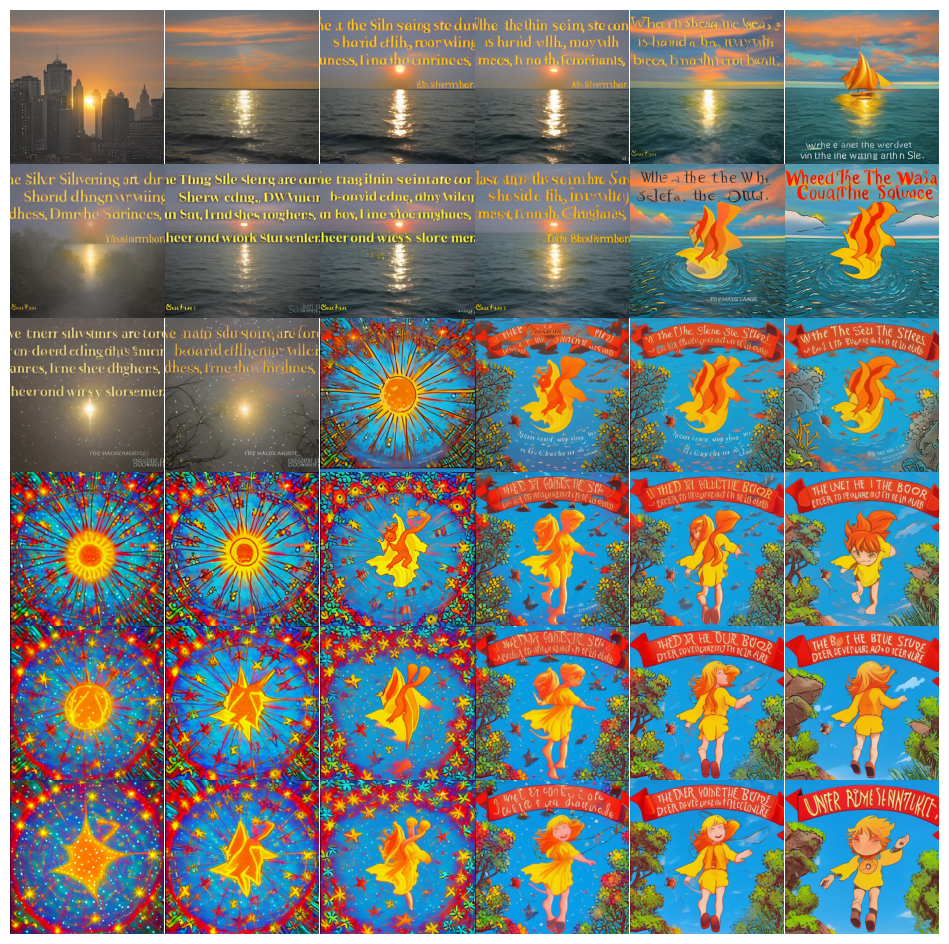

In [9]:
images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)